In [1]:
#Import relevant libraries
import pandas as pd
import numpy as np


from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
%matplotlib inline

### Define useful functions

In [2]:
#Define Function to compare accuracy scores
def accuracy_comp(y_train, p_train, y_test, p_test):
    """This function compares the accuracy scores of train and test sets
    predictions"""
    
    train_accuracy = accuracy_score(y_train, p_train)
    test_accuracy = accuracy_score(y_test, p_test)
        
    print(f"Training Accuracy: {(train_accuracy * 100):.4}%")
    print(f"Test Accuracy:     {(test_accuracy * 100):.4}%")
    

### Import Datasets

In [3]:
# 1) Import Training Data
df = pd.read_csv('Data/data_for_modeling.csv')
df.head()

,id,status_group,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,basin,...,extraction_type,extraction_type_class,management,management_group,payment,water_quality,quantity_group,source,source_class,waterpoint_type
0,69572,functional,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,Lake Nyasa,...,gravity,gravity,vwc,user-group,pay annually,soft,enough,spring,groundwater,communal standpipe
1,8776,functional,0.0,Grumeti,1399,Grumeti,34.698766,-2.147466,Zahanati,Lake Victoria,...,gravity,gravity,wug,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe
2,34310,functional,25.0,Lottery Club,686,World Vision,37.460664,-3.821329,Kwa Mahundi,Pangani,...,gravity,gravity,vwc,user-group,pay per bucket,soft,enough,dam,surface,communal standpipe multiple
3,67743,non functional,0.0,Unicef,263,Unicef,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,...,submersible,submersible,vwc,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple
4,19728,functional,0.0,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,Lake Victoria,...,gravity,gravity,other,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe


In [4]:
#Check Column names
df.columns

Index(['id', 'status_group', 'amount_tsh', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_class', 'management',
       'management_group', 'payment', 'water_quality', 'quantity_group',
       'source', 'source_class', 'waterpoint_type'],
      dtype='object')

### Preping the Data

In [5]:
#Create new dataframe for modeling
#Drop uninteresting columns
dfmod = df.drop(['id', 'status_group', 'wpt_name'], axis = 1)

In [6]:
#Define target
target = df['status_group']

In [7]:
#Defining categorical and cntinuous features
con_feats = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 
            'population', 'construction_year']
cat_feats = list(dfmod.drop(con_feats, axis = 1).columns)

In [8]:
#Drop categorical features with too many unique values
to_remove = ['funder', 'installer', 'subvillage', 'ward']
for label in to_remove:
    cat_feats.remove(label)

#Check list
print(cat_feats)

['basin', 'region', 'region_code', 'district_code', 'lga', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_class', 'management', 'management_group', 'payment', 'water_quality', 'quantity_group', 'source', 'source_class', 'waterpoint_type']


In [9]:
#Create dummy variables
dummy = pd.get_dummies(df[cat_feats], drop_first = True)
dummy.shape

(59400, 240)

In [10]:
#Finalise dfmod for modeling
dfmod.drop(cat_feats, axis = 1, inplace = True)
dfmod.drop(to_remove, axis = 1, inplace = True)

dfmod = pd.concat ([dfmod, dummy], axis = 1)
dfmod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Columns: 246 entries, amount_tsh to waterpoint_type_other
dtypes: bool(2), float64(3), int64(5), uint8(236)
memory usage: 17.1 MB


In [11]:
#Preview
dfmod.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,region_code,district_code,public_meeting,permit,...,source_spring,source_unknown,source_class_surface,source_class_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,6000.0,1390,34.938093,-9.856322,109,1999,11,5,True,False,...,1,0,0,0,1,0,0,0,0,0
1,0.0,1399,34.698766,-2.147466,280,2010,20,2,True,True,...,0,0,1,0,1,0,0,0,0,0
2,25.0,686,37.460664,-3.821329,250,2009,21,4,True,True,...,0,0,1,0,0,1,0,0,0,0
3,0.0,263,38.486161,-11.155298,58,1986,90,63,True,True,...,0,0,0,0,0,1,0,0,0,0
4,0.0,0,31.130847,-1.825359,0,0,18,1,True,True,...,0,0,1,0,1,0,0,0,0,0


In [12]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(dfmod, target, random_state = 123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((44550, 246), (14850, 246), (44550,), (14850,))

In [13]:
#Instantial StandardScaler
scaler = StandardScaler()

#Transform the train and test sets
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Convert to DataFrae
X_train = pd.DataFrame(X_train, columns = dfmod.columns)
X_train.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,region_code,district_code,public_meeting,permit,...,source_spring,source_unknown,source_class_surface,source_class_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,-0.022712,0.894765,-0.617815,0.471225,0.713149,0.715964,0.043826,-0.376825,0.30638,0.718279,...,-0.636194,-0.034837,1.856250,-0.06882,1.038029,-0.33636,-0.010595,-0.644941,-0.11585,-0.347741
1,-0.116621,1.252187,-0.462652,-0.609940,-0.376516,0.728575,-0.013390,-0.272579,0.30638,-1.392216,...,-0.636194,-0.034837,-0.538721,-0.06882,-0.963364,-0.33636,-0.010595,1.550529,-0.11585,-0.347741
2,-0.127056,1.484223,0.252646,-0.765700,-0.376516,0.742236,-0.242257,-0.481072,0.30638,0.718279,...,-0.636194,-0.034837,-0.538721,-0.06882,-0.963364,-0.33636,-0.010595,1.550529,-0.11585,-0.347741
3,-0.127056,-0.965849,-0.332504,0.808518,-0.378616,-1.366906,0.101043,-0.064085,0.30638,0.718279,...,-0.636194,-0.034837,-0.538721,-0.06882,-0.963364,-0.33636,-0.010595,1.550529,-0.11585,-0.347741
4,0.499004,-0.431156,0.500722,-1.953200,-0.376516,0.742236,-0.299473,-0.481072,0.30638,-1.392216,...,-0.636194,-0.034837,-0.538721,-0.06882,-0.963364,-0.33636,-0.010595,1.550529,-0.11585,-0.347741


### KNN

In [14]:
#Instantiate Classifier
KNN = KNeighborsClassifier()

#Fit model
KNN.fit(X_train, y_train)

KNeighborsClassifier()

In [15]:
#Predict
train_pred = KNN.predict(X_train)
test_pred = KNN.predict(X_test)

In [16]:
#Compare Accuracy Scores
accuracy_comp(y_train, train_pred, y_test, test_pred)

#Print Classification Report
print('\n Classification Report: \n', classification_report(y_test, test_pred))

Training Accuracy: 82.94%
Test Accuracy:     76.32%

 Classification Report: 
                          precision    recall  f1-score   support

             functional       0.77      0.85      0.81      7963
functional needs repair       0.47      0.33      0.39      1076
         non functional       0.80      0.72      0.76      5811

               accuracy                           0.76     14850
              macro avg       0.68      0.63      0.65     14850
           weighted avg       0.76      0.76      0.76     14850



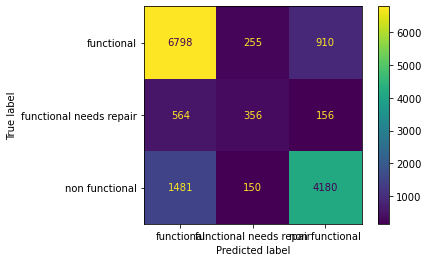

In [17]:
#Plot a confusion matrix
plot_confusion_matrix(KNN, X_test, y_test);

### Random Forest

In [19]:
#Instantiate RandomForest Classifier
forest = RandomForestClassifier()

In [33]:
#Use GridSerchCV to determine best parameters
rf_param_grid = {'n_estimators': [100, 200, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5] }

#Instantiate GridSearchCV
rf_grid_search = GridSearchCV(forest, rf_param_grid, cv = 3)

#Fit to the data
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(criterion='entropy', max_depth=10,
                                              min_samples_leaf=2,
                                              min_samples_split=5),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6], 'min_samples_leaf': [2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]})

In [34]:
#Check best params
print(rf_grid_search.best_params_)

{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [21]:
#Check best params
print(rf_grid_search.best_params_)
#{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [23]:
#Instantiate and train RandomForest with the determined params
forest = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 10, 
                                min_samples_leaf = 2, min_samples_split = 5)
forest.fit(X_train, y_train)

#Predict train and test sets
train_pred = forest.predict(X_train)
test_pred = forest.predict(X_test)

In [24]:
#Check accuracy score and classification report
accuracy_comp(y_train, train_pred, y_test, test_pred)
print('\n Classification Report: \n', classification_report(y_test, test_pred))

Training Accuracy: 72.98%
Test Accuracy:     71.98%

 Classification Report: 
                          precision    recall  f1-score   support

             functional       0.68      0.95      0.79      7963
functional needs repair       0.65      0.08      0.14      1076
         non functional       0.85      0.53      0.65      5811

               accuracy                           0.72     14850
              macro avg       0.72      0.52      0.53     14850
           weighted avg       0.74      0.72      0.69     14850



### Model Tuning

#### 1. Addressing Class Imbalance using SMOTE

In [25]:
#Instantiate and train
smote = SMOTE()

X_smote, y_smote = smote.fit_sample(X_train, y_train)

In [26]:
#New Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, random_state = 123)

In [30]:
#New Model
forest2 = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 10, 
                                min_samples_leaf = 2, min_samples_split = 5)
forest2.fit(X_train, y_train)

#Predict train and test sets
train_pred = forest2.predict(X_train)
test_pred = forest2.predict(X_test)

In [31]:
#Verify accuracy and classification report
accuracy_comp(y_train, train_pred, y_test, test_pred)
print('\n Classification Report: \n', classification_report(y_test, test_pred))

Training Accuracy: 73.77%
Test Accuracy:     72.53%

 Classification Report: 
                          precision    recall  f1-score   support

             functional       0.68      0.69      0.69      6104
functional needs repair       0.70      0.85      0.77      6021
         non functional       0.82      0.64      0.72      6097

               accuracy                           0.73     18222
              macro avg       0.73      0.73      0.72     18222
           weighted avg       0.73      0.73      0.72     18222



#### 2. Feature Measurement

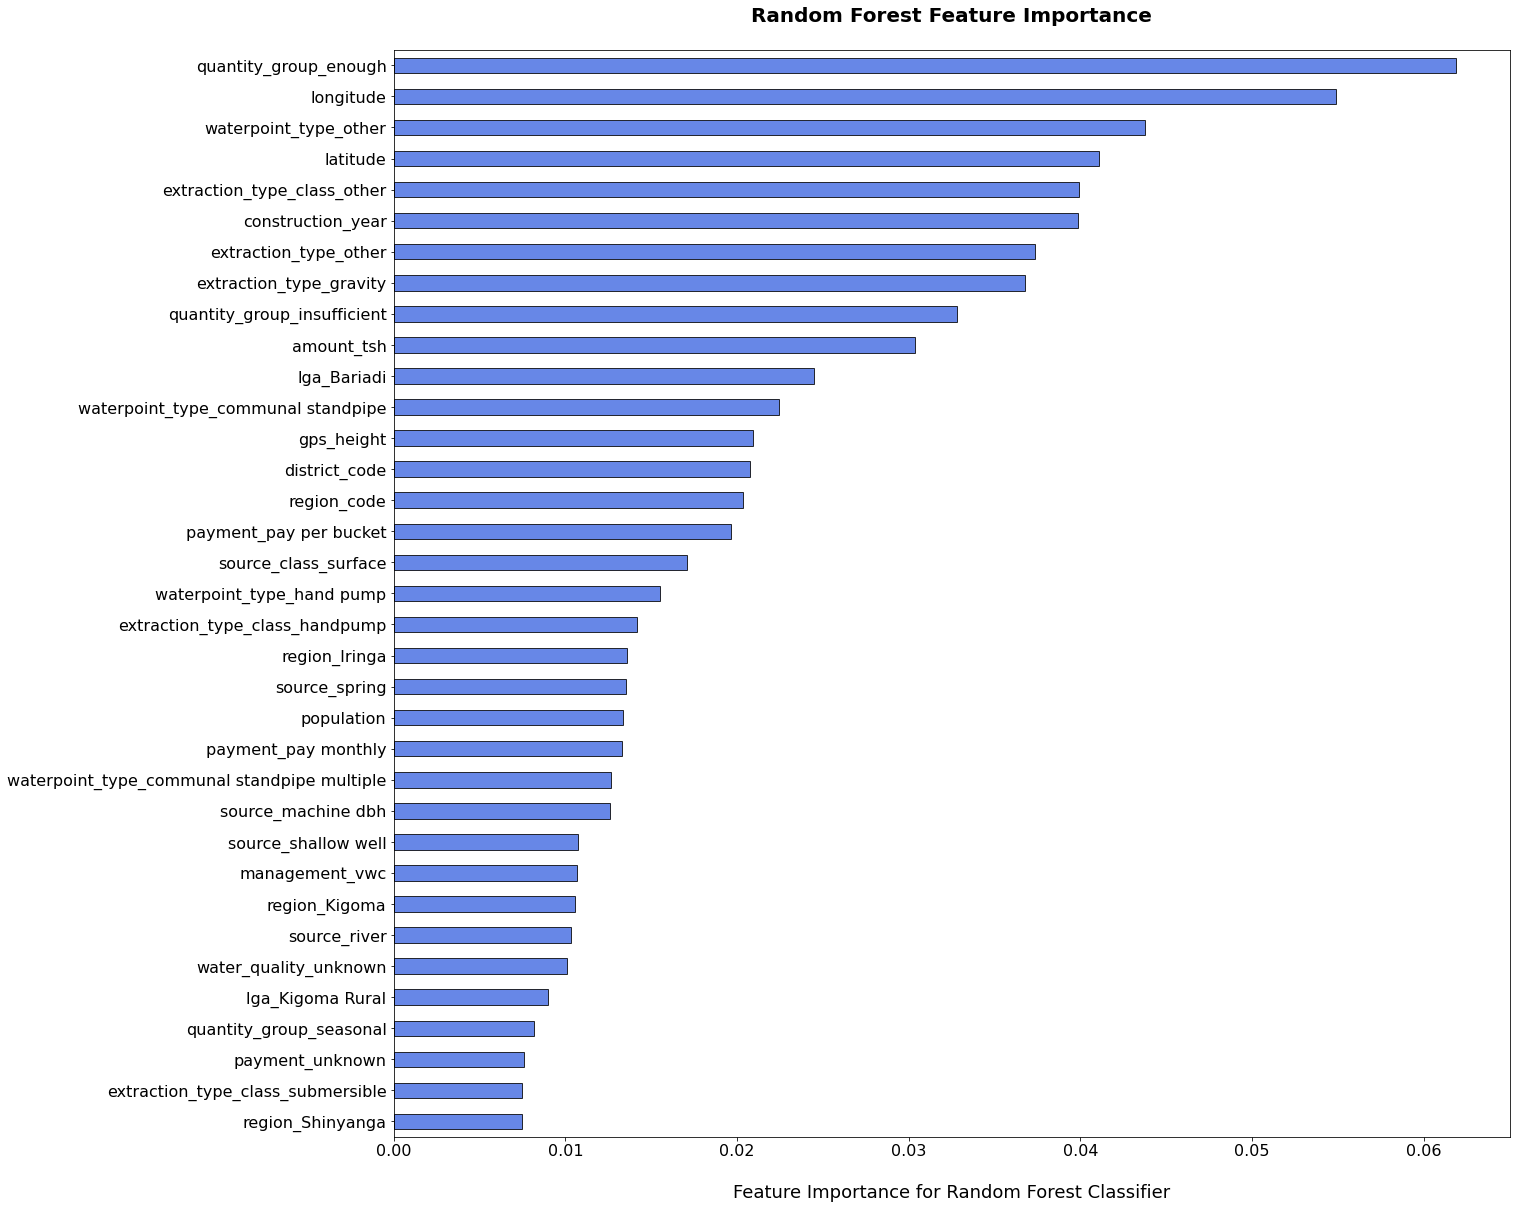

In [32]:
#Check the most important features in the RandomForest model
features = pd.Series(forest2.feature_importances_, index=dfmod.columns)
features.nlargest(35).sort_values().plot(kind='barh',figsize=(20,20), edgecolor = 'black',
                                                         color = 'royalblue', alpha = .8)

plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
plt.xlabel('\nFeature Importance for Random Forest Classifier', fontsize = 18)

plt.title("Random Forest Feature Importance\n", fontsize = 20, fontweight = 'bold');